In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn import svm
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
import seaborn as sns

pd.options.mode.chained_assignment = None #set it to None to remove SettingWithCopyWarning
pd.options.display.float_format = '{:.4f}'.format #set it to convert scientific noations such as 4.225108e+11 to 422510842796.00
pd.set_option('display.max_columns', 100) # to display all the columns

np.set_printoptions(suppress=True,formatter={'float_kind':'{:f}'.format})

import os

import warnings
warnings.filterwarnings('ignore') # if there are any warning due to version mismatch, it will be ignored

In [11]:
loan=pd.read_csv("C:\\Users\\Kavitha\\Desktop\\Lending_club\\Lending_Club_Loan_2007_2011.csv",skiprows=1, low_memory=False)
try:
    print("The loan dataset has {} samples with {} features.".format(*loan.shape))
except:
    print("The loan dataset could not be loaded. Is the dataset missing?")
    

    

The loan dataset has 42542 samples with 147 features.


In [12]:
def removeNulls(dataframe, axis =1, percent=0.3):
  
    df = dataframe.copy()
    ishape = df.shape
    if axis == 0:
        rownames = df.transpose().isnull().sum()
        rownames = list(rownames[rownames.values > percent*len(df)].index)
        df.drop(df.index[rownames],inplace=True) 
        print("\nNumber of Rows dropped\t: ",len(rownames))
    else:
        colnames = (df.isnull().sum()/len(df))
        colnames = list(colnames[colnames.values>=percent].index)
        df.drop(labels = colnames,axis =1,inplace=True)        
        print("Number of Columns dropped\t: ",len(colnames))
        
    print("\nOld dataset rows,columns",ishape,"\nNew dataset rows,columns",df.shape)

    return df

In [13]:
loan = removeNulls(loan, axis =1,percent = 0.3)
loan = removeNulls(loan, axis =0,percent = 0.3)

Number of Columns dropped	:  91

Old dataset rows,columns (42542, 147) 
New dataset rows,columns (42542, 56)

Number of Rows dropped	:  0

Old dataset rows,columns (42542, 56) 
New dataset rows,columns (42542, 56)


In [14]:
unique = loan.nunique()
unique = unique[unique.values == 1]

In [15]:
loan.drop(labels = list(unique.index), axis =1, inplace=True)
print("So now we are left with",loan.shape ,"rows & columns.")

So now we are left with (42542, 45) rows & columns.


In [16]:
print(loan.emp_length.unique())
loan.emp_length.fillna('0',inplace=True)
loan.emp_length.replace(['n/a'],'Self-Employed',inplace=True)
print(loan.emp_length.unique())

['10+ years' '< 1 year' '1 year' '3 years' '8 years' '9 years' '4 years'
 '5 years' '6 years' '2 years' '7 years' nan]
['10+ years' '< 1 year' '1 year' '3 years' '8 years' '9 years' '4 years'
 '5 years' '6 years' '2 years' '7 years' '0']


In [17]:
not_required_columns = ["id","zip_code"]
loan.drop(labels = not_required_columns, axis =1, inplace=True)
print("So now we are left with",loan.shape ,"rows & columns.")

So now we are left with (42542, 43) rows & columns.


In [18]:
numeric_columns = ['loan_amnt','funded_amnt','funded_amnt_inv','installment','int_rate','annual_inc','dti']
loan["int_rate"]=loan["int_rate"].str.rstrip("%").astype("float")
loan[numeric_columns] = loan[numeric_columns].apply(pd.to_numeric)

In [19]:
loan.tail(3)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_fico_range_high,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,acc_now_delinq,delinq_amnt,pub_rec_bankruptcies,tax_liens,debt_settlement_flag
42539,nan,nan,nan,NaN,nan,nan,NaN,NaN,NaN,0,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,NaN,nan,nan,nan,nan,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,nan,NaN,nan,nan,nan,nan,NaN
42540,nan,nan,nan,NaN,nan,nan,NaN,NaN,NaN,0,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,NaN,nan,nan,nan,nan,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,nan,NaN,nan,nan,nan,nan,NaN
42541,nan,nan,nan,NaN,nan,nan,NaN,NaN,NaN,0,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,NaN,nan,nan,nan,nan,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,nan,NaN,nan,nan,nan,nan,NaN


In [20]:
(loan.purpose.value_counts()*100)/len(loan)

debt_consolidation   46.4858
credit_card          12.8743
other                10.4015
home_improvement      7.5196
major_purchase        5.4323
small_business        4.6824
car                   3.7962
wedding               2.3600
medical               1.7700
moving                1.4785
house                 1.0014
educational           0.9920
vacation              0.9402
renewable_energy      0.2492
Name: purpose, dtype: float64

In [21]:
del_loan_purpose = (loan.purpose.value_counts()*100)/len(loan)
del_loan_purpose = del_loan_purpose[(del_loan_purpose < 0.75) | (del_loan_purpose.index == 'other')]

loan.drop(labels = loan[loan.purpose.isin(del_loan_purpose.index)].index, inplace=True)
print("So now we are left with",loan.shape ,"rows & columns.")

print(loan.purpose.unique())

So now we are left with (38011, 43) rows & columns.
['credit_card' 'car' 'small_business' 'wedding' 'debt_consolidation'
 'home_improvement' 'major_purchase' 'medical' 'moving' 'vacation' 'house'
 'educational' nan]


In [22]:
(loan.loan_status.value_counts()*100)/len(loan)

Fully Paid                                            80.6819
Charged Off                                           13.1909
Does not meet the credit policy. Status:Fully Paid     4.4277
Does not meet the credit policy. Status:Charged Off    1.6811
Name: loan_status, dtype: float64

In [23]:
del_loan_status = (loan.loan_status.value_counts()*100)/len(loan)
del_loan_status = del_loan_status[(del_loan_status < 1.5)]

loan.drop(labels = loan[loan.loan_status.isin(del_loan_status.index)].index, inplace=True)
print("So now we are left with",loan.shape ,"rows & columns.")

print(loan.loan_status.unique())

So now we are left with (38011, 43) rows & columns.
['Fully Paid' 'Charged Off' nan
 'Does not meet the credit policy. Status:Charged Off'
 'Does not meet the credit policy. Status:Fully Paid']


In [24]:
loan['loan_income_ratio']= loan['loan_amnt']/loan['annual_inc']

In [25]:
loan['issue_month'],loan['issue_year'] = loan['issue_d'].str.split('-', 1).str
loan[['issue_d','issue_month','issue_year']].head()

,issue_d,issue_month,issue_year
0,Dec-11,Dec,11
1,Dec-11,Dec,11
2,Dec-11,Dec,11
5,Dec-11,Dec,11
6,Dec-11,Dec,11


In [26]:
months_order = ["Jan", "Feb", "Mar", "Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
loan['issue_month'] = pd.Categorical(loan['issue_month'],categories=months_order, ordered=True)


In [27]:
bins = [0, 5000, 10000, 15000, 20000, 25000,40000]
slot = ['0-5000', '5000-10000', '10000-15000', '15000-20000', '20000-25000','25000 and above']
loan['loan_amnt_range'] = pd.cut(loan['loan_amnt'], bins, labels=slot)


In [28]:
bins = [0, 25000, 50000, 75000, 100000,1000000]
slot = ['0-25000', '25000-50000', '50000-75000', '75000-100000', '100000 and above']
loan['annual_inc_range'] = pd.cut(loan['annual_inc'], bins, labels=slot)

In [29]:
bins = [0, 7.5, 10, 12.5, 15,20]
slot = ['0-7.5', '7.5-10', '10-12.5', '12.5-15', '15 and above']
loan['int_rate_range'] = pd.cut(loan['int_rate'], bins, labels=slot)

In [30]:
def univariate(df,col,vartype,hue =None):
    
    '''
    Univariate function will plot the graphs based on the parameters.
    df      : dataframe name
    col     : Column name
    vartype : variable type : continuos or categorical
                Continuos(0)   : Distribution, Violin & Boxplot will be plotted.
                Categorical(1) : Countplot will be plotted.
    hue     : It's only applicable for categorical analysis.
    
    '''
    sns.set(style="darkgrid")
    
    if vartype == 0:
        fig, ax=plt.subplots(nrows =1,ncols=3,figsize=(20,8))
        ax[0].set_title("Distribution Plot")
        '''df[df[col].isnull()]
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df = df.dropna(subset=[df[col]])
        df[col] = df[col].astype(int)'''
        
        df = df.dropna()
        sns.distplot(df[col],ax=ax[0])
        ax[1].set_title("Violin Plot")
        sns.violinplot(data =df, x=col,ax=ax[1], inner="quartile")
        ax[2].set_title("Box Plot")
        sns.boxplot(data =df, x=col,ax=ax[2],orient='v')
    
    if vartype == 1:
        temp = pd.Series(data = hue)
        fig, ax = plt.subplots()
        width = len(df[col].unique()) + 6 + 4*len(temp.unique())
        fig.set_size_inches(width , 7)
        ax = sns.countplot(data = df, x= col, order=df[col].value_counts().index,hue = hue) 
        if len(temp.unique()) > 0:
            for p in ax.patches:
                ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float(len(loan))), (p.get_x()+0.05, p.get_height()+20))  
        else:
            for p in ax.patches:
                ax.annotate(p.get_height(), (p.get_x()+0.32, p.get_height()+20)) 
        del temp
    else:
        exit
        
    plt.show()

# 1. Loan Amount


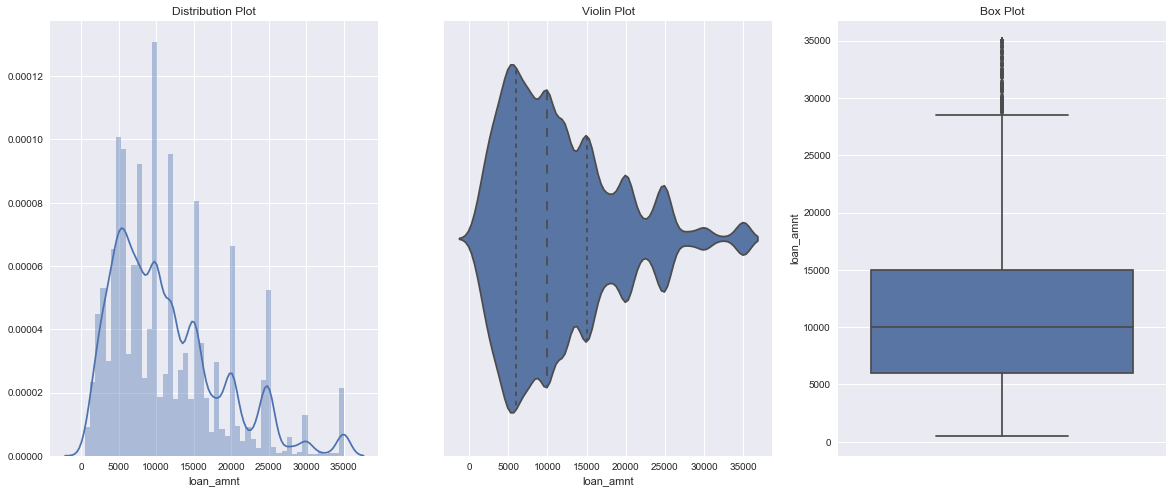

In [31]:
univariate(df=loan,col='loan_amnt',vartype=0)

Insights: Most of the loan amounts are distributed between 6000 to 15000 USD.

# 2. Interest Rate

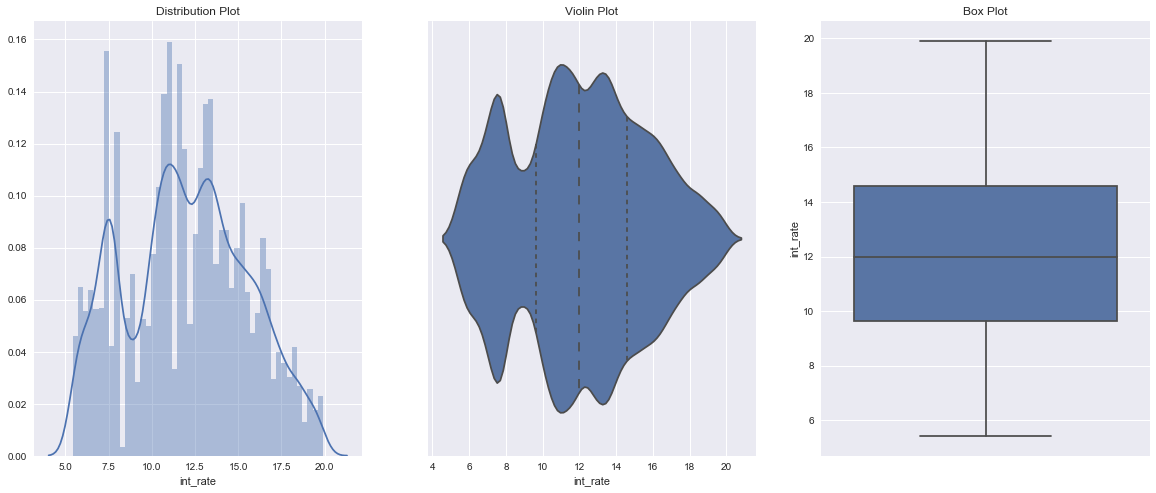

In [32]:
univariate(df=loan,col='int_rate',vartype=0)


Insights: Most of the loans interest rates are distributed between 9.5% to 14.5%.

# 3 Annual Income

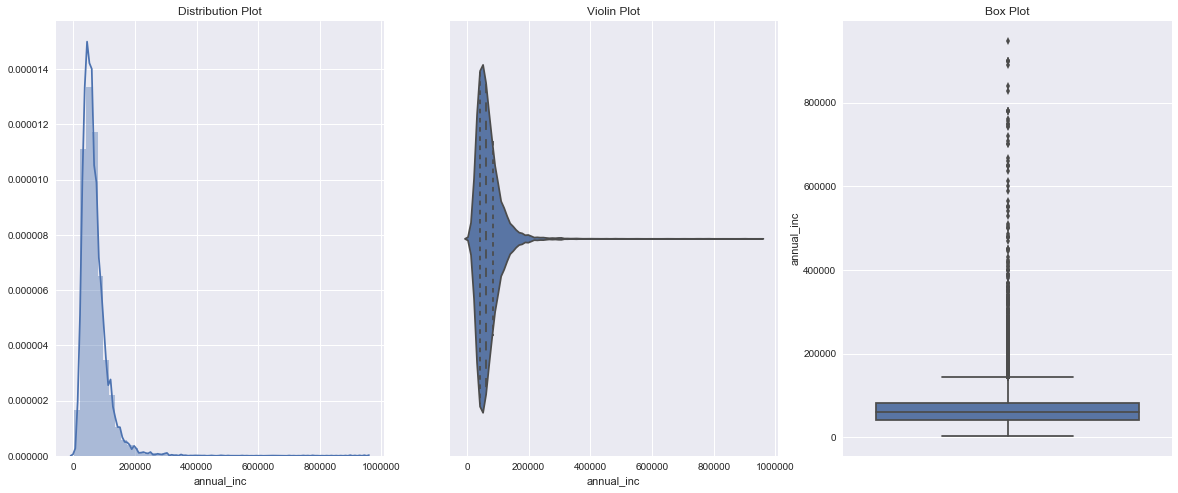

In [33]:
univariate(df=loan,col='annual_inc',vartype=0)

# Loan Status

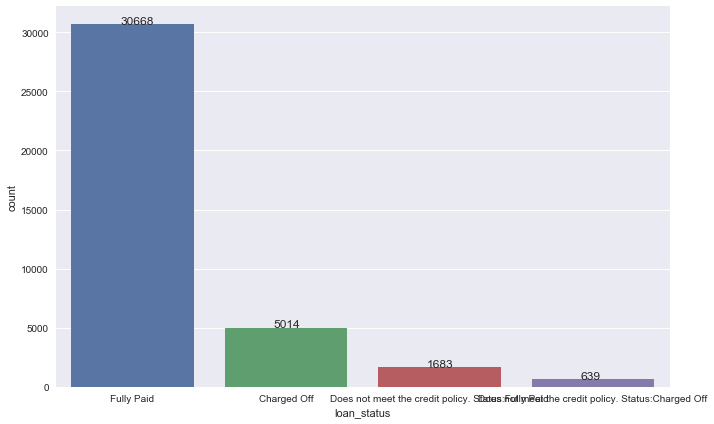

In [34]:
univariate(df=loan,col='loan_status',vartype=1)

Insights: 15% of the applicants Charged off.

# Purpose of Loan

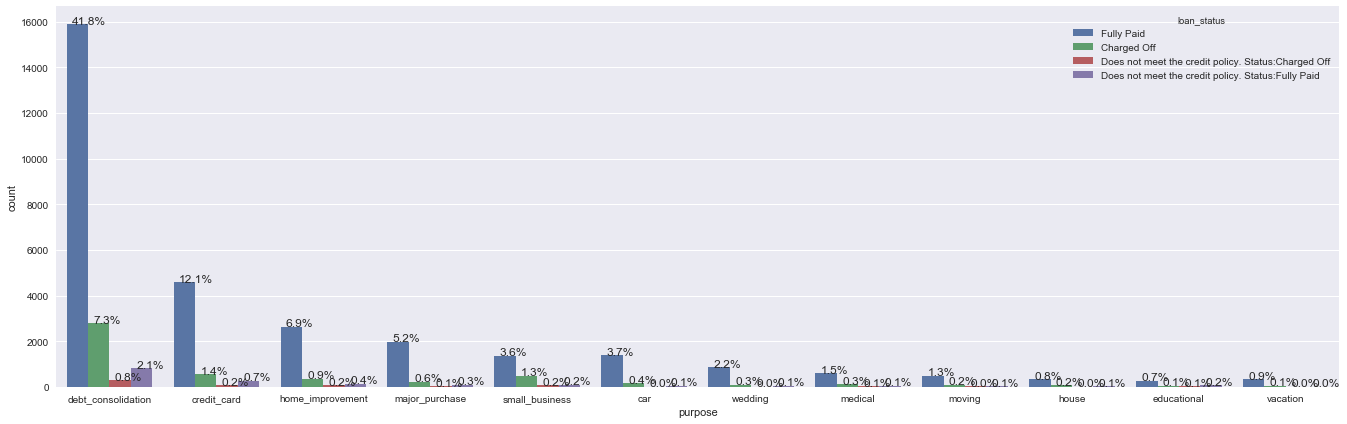

In [35]:
univariate(df=loan,col='purpose',vartype=1,hue='loan_status')

Insights: Approx 50% of the applicants applied loan for paying their other loans(Debt Consolidation).

8. Loan Term

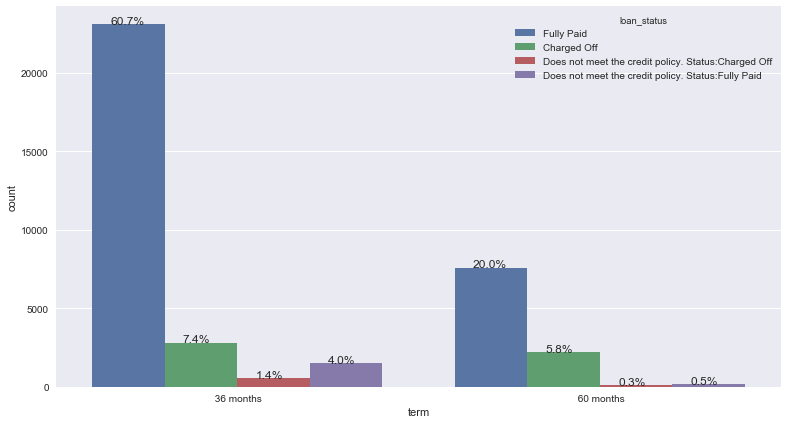

In [36]:
univariate(df=loan,col='term',vartype=1,hue='loan_status')

In [37]:
 74% of applicants applied loan for 36 months term period.

SyntaxError: invalid syntax (<ipython-input-37-59d2493fa086>, line 1)

# Bivariate/Multivariate Analysis

In [38]:
def crosstab(df,col):
    crosstab = pd.crosstab(df[col], df['loan_status'],margins=True)
    crosstab['Probability_Charged Off'] = round((crosstab['Charged Off']/crosstab['All']),3)
    crosstab = crosstab[0:-1]
    return crosstab

In [39]:
def bivariate_prob(df,col,stacked= True):
   
    # get dataframe from crosstab function
    plotCrosstab = crosstab(df,col)
    
    linePlot = plotCrosstab[['Probability_Charged Off']]      
    barPlot =  plotCrosstab.iloc[:,0:2]
    ax = linePlot.plot(figsize=(20,8), marker='o',color = 'b')
    ax2 = barPlot.plot(kind='bar',ax = ax,rot=1,secondary_y=True,stacked=stacked)
    ax.set_title(df[col].name.title()+' vs Probability Charge Off',fontsize=20,weight="bold")
    ax.set_xlabel(df[col].name.title(),fontsize=14)
    ax.set_ylabel('Probability of Charged off',color = 'b',fontsize=14)
    ax2.set_ylabel('Number of Applicants',color = 'g',fontsize=14)
    plt.show()

# 1.Location vs Probability Charge Off¶


In [40]:
filter_states = loan.addr_state.value_counts()
filter_states = filter_states[(filter_states < 10)]

loan_filter_states = loan.drop(labels = loan[loan.addr_state.isin(filter_states.index)].index)

loan_status,Charged Off,Does not meet the credit policy. Status:Charged Off,Does not meet the credit policy. Status:Fully Paid,Fully Paid,All,Probability_Charged Off
addr_state,,,,,,
NJ,259,22,89,1414,1784,0.1450
NM,30,1,11,148,190,0.1580
NV,91,14,9,348,462,0.1970
NY,438,48,152,2922,3560,0.1230
OH,141,18,72,974,1205,0.1170
OK,36,3,12,229,280,0.1290
OR,68,6,11,345,430,0.1580
PA,161,36,82,1183,1462,0.1100
RI,24,2,6,150,182,0.1320


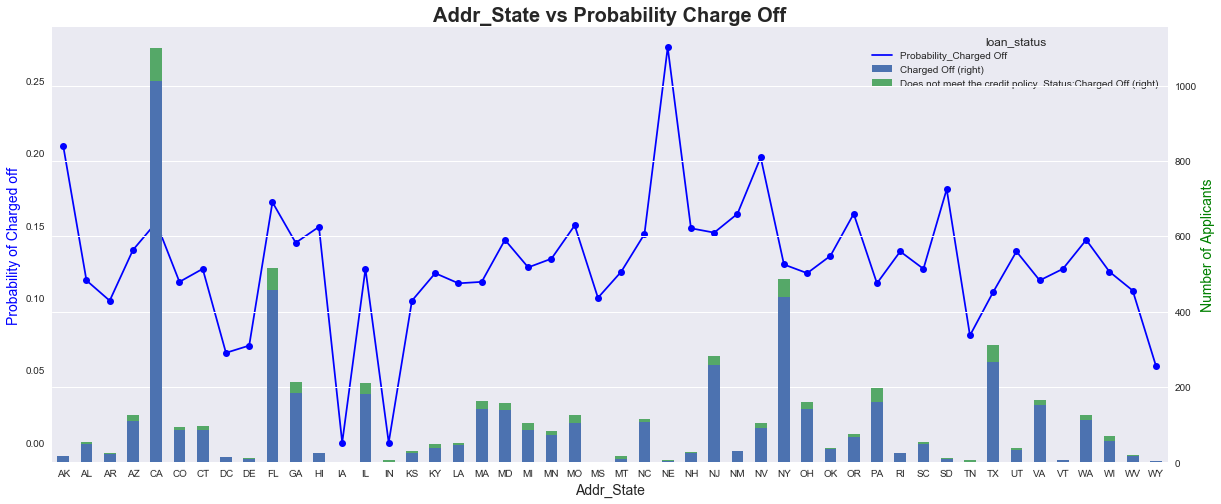

In [41]:
states = crosstab(loan_filter_states,'addr_state')
display(states.tail(20))

bivariate_prob(df =loan_filter_states,col ='addr_state')

In [42]:
Inights: There are multiple States/Provinces with high probability of charge,highest being 'NE' at 3%

SyntaxError: invalid syntax (<ipython-input-42-ef81fdf55508>, line 1)

# 2. Purpose of Loan vs Probability Charge Off

loan_status,Charged Off,Does not meet the credit policy. Status:Charged Off,Does not meet the credit policy. Status:Fully Paid,Fully Paid,All,Probability_Charged Off
purpose,,,,,,
car,160,13,51,1391,1615,0.0990
credit_card,548,69,271,4589,5477,0.1000
debt_consolidation,2792,292,808,15884,19776,0.1410
educational,56,32,65,269,422,0.1330
home_improvement,351,71,143,2634,3199,0.1100
house,59,11,33,323,426,0.1380
major_purchase,222,23,100,1966,2311,0.0960
medical,106,22,36,589,753,0.1410
moving,92,15,31,491,629,0.1460


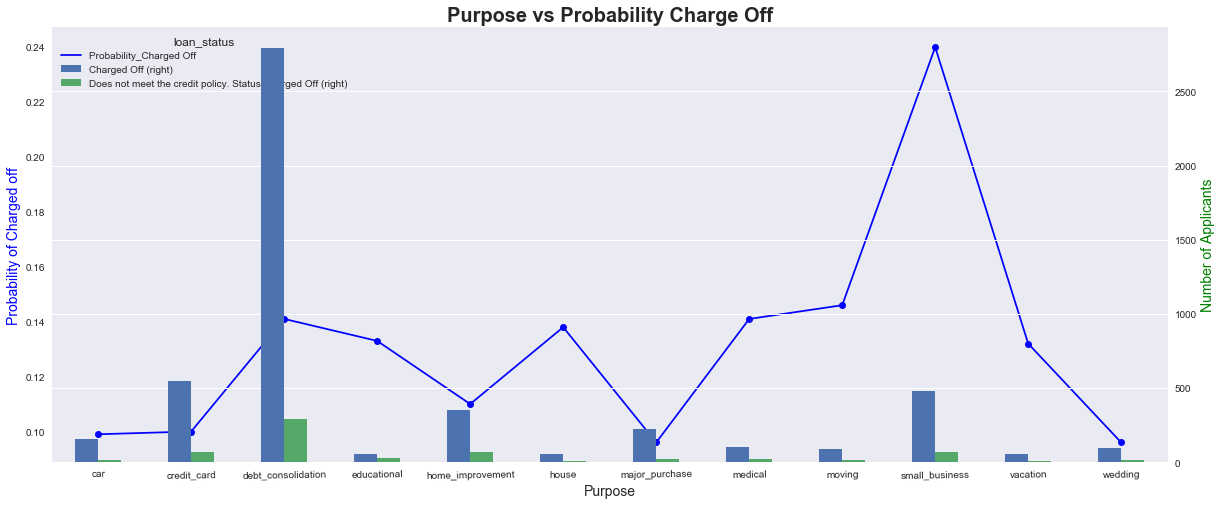

In [43]:
purpose = crosstab(loan,'purpose')
display(purpose)

bivariate_prob(df =loan,col ='purpose',stacked=False)

Insights: Applicants who has taken the Loan for 'small business' has the highest probabilty of charge off of 24%. So bank should take extra caution like take some asset or guarentee while approving the loan for purpose of 'small business'

# 3. Grade/Subgrade vs Probability Charge Off

loan_status,Charged Off,Does not meet the credit policy. Status:Charged Off,Does not meet the credit policy. Status:Fully Paid,Fully Paid,All,Probability_Charged Off
grade,,,,,,
A,514,7,62,8452,9035,0.0570
B,1264,71,212,9519,11066,0.1140
C,1181,127,399,6058,7765,0.1520
D,1005,159,431,3805,5400,0.1860
E,658,132,330,1965,3085,0.2130
F,302,81,138,665,1186,0.2550
G,90,62,111,204,467,0.1930


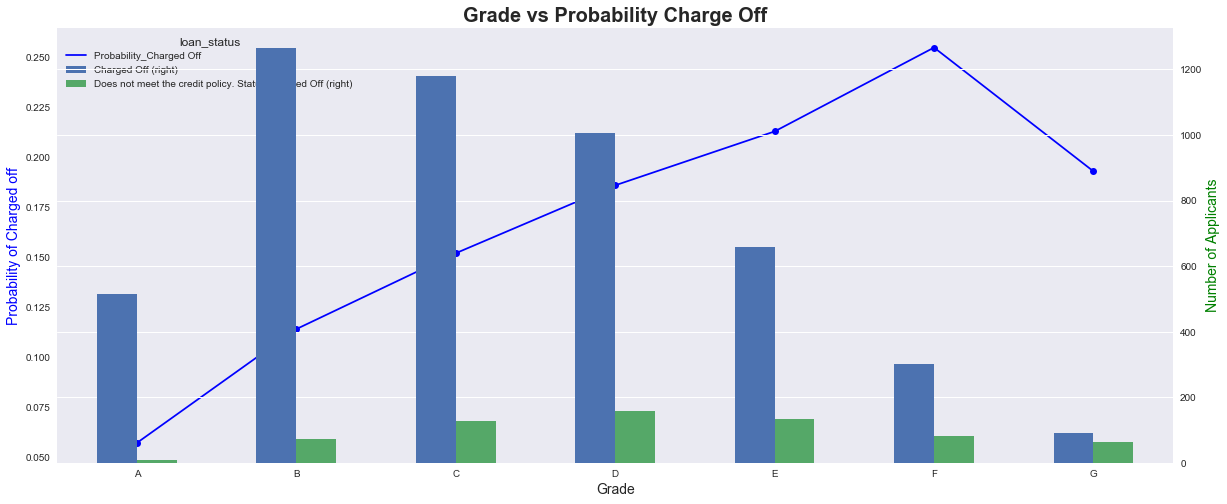

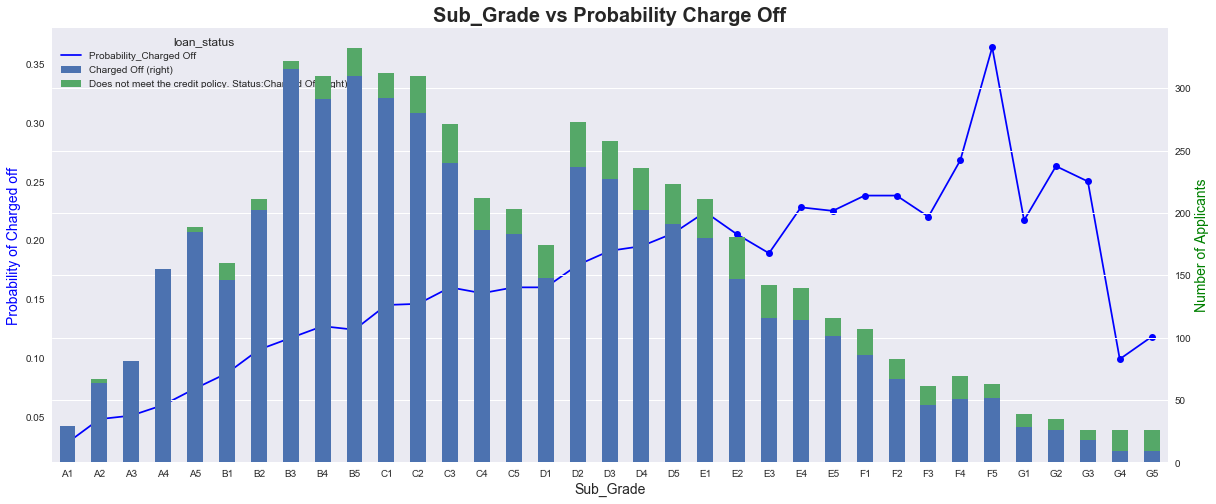

In [44]:
grade = crosstab(loan,'grade')
display(grade)

bivariate_prob(df =loan,col ='grade',stacked=False)
bivariate_prob(df =loan,col ='sub_grade')

Insights: As we move from Grade A to F, probability that person will charged off is increasing.

# 4. Annual Income Range vs Probability Charge Off¶

loan_status,Charged Off,Does not meet the credit policy. Status:Charged Off,Does not meet the credit policy. Status:Fully Paid,Fully Paid,All,Probability_Charged Off
annual_inc_range,,,,,,
0-25000,387,64,170,1731,2352,0.1650
25000-50000,1881,223,528,9845,12477,0.1510
50000-75000,1535,175,427,9394,11531,0.1330
75000-100000,681,86,287,5028,6082,0.1120
100000 and above,529,91,270,4659,5549,0.0950


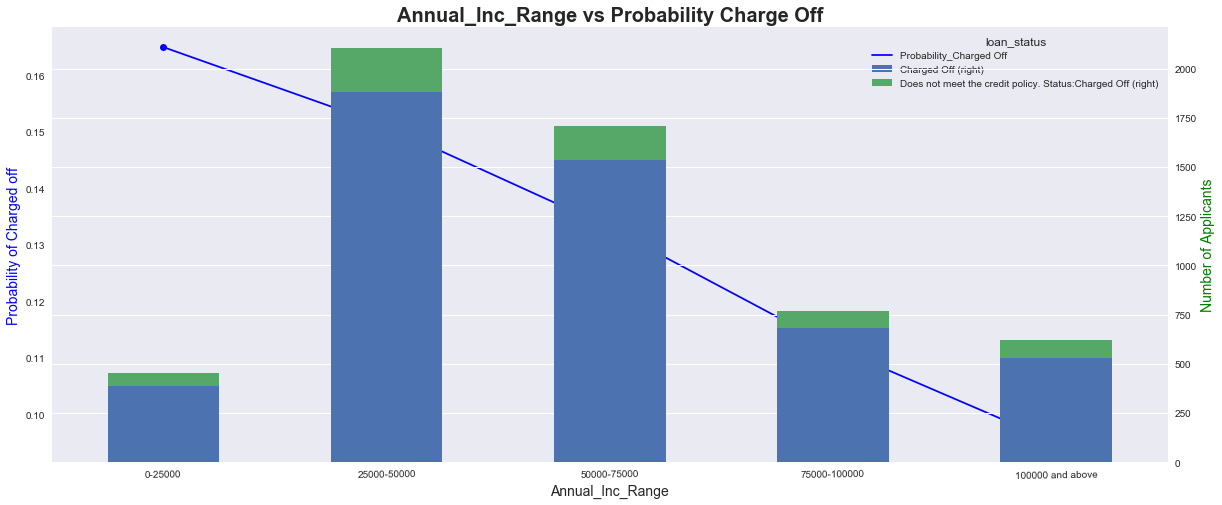

In [45]:
annual_inc_range = crosstab(loan,'annual_inc_range')
display(annual_inc_range)

bivariate_prob(df =loan,col ='annual_inc_range')

Insights: As the annual income is decreasing the probability that person will default is increasing with highest of 16% at (0 to 25000) salary bracket.

# 5. Interest rate Range vs Probability Charge Off

loan_status,Charged Off,Does not meet the credit policy. Status:Charged Off,Does not meet the credit policy. Status:Fully Paid,Fully Paid,All,Probability_Charged Off
int_rate_range,,,,,,
0-7.5,224,2,13,4600,4839,0.0460
7.5-10,485,25,104,5756,6370,0.0760
10-12.5,1104,105,278,7527,9014,0.1220
12.5-15,1298,230,684,6875,9087,0.1430
15 and above,1628,259,570,5376,7833,0.2080


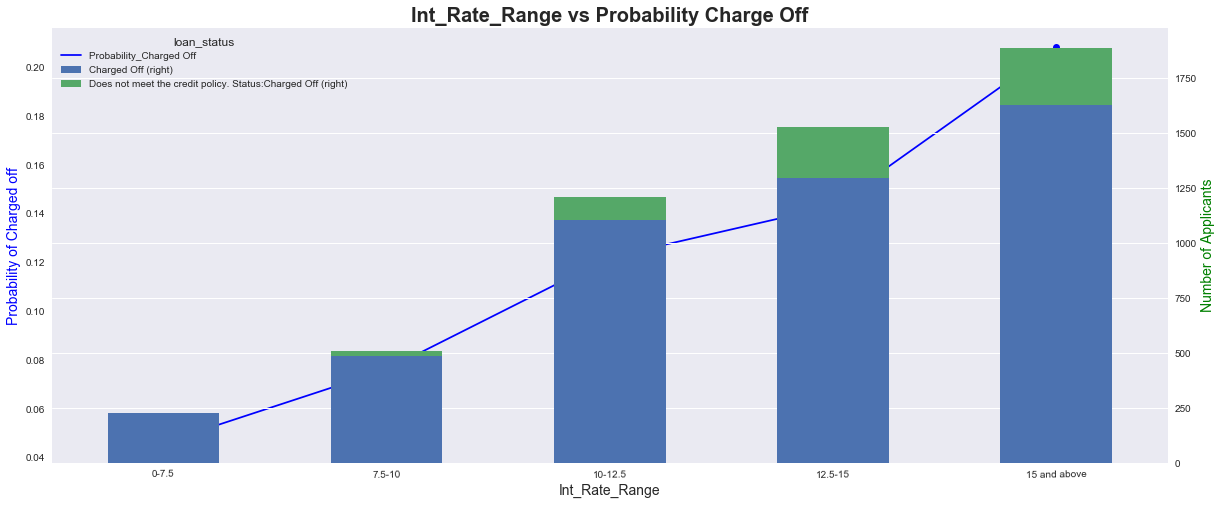

In [46]:
int_rate_range = crosstab(loan,'int_rate_range')
display(int_rate_range)

bivariate_prob(df =loan,col ='int_rate_range')

Insights: As the interest rate is increasing the probability that person will default is increasing with highest of 20% at 15% & above bracket

# 6. Employment Length vs Probability Charge Off

loan_status,Charged Off,Does not meet the credit policy. Status:Charged Off,Does not meet the credit policy. Status:Fully Paid,Fully Paid,All,Probability_Charged Off
emp_length,,,,,,
0,192,14,15,717,938,0.2050
1 year,402,76,221,2472,3171,0.1270
10+ years,1202,127,264,6814,8407,0.1430
2 years,492,73,222,3441,4228,0.1160
3 years,491,62,168,3203,3924,0.1250
4 years,409,50,123,2701,3283,0.1250
5 years,416,44,110,2556,3126,0.1330
6 years,280,34,84,1755,2153,0.1300
7 years,234,26,56,1361,1677,0.1400


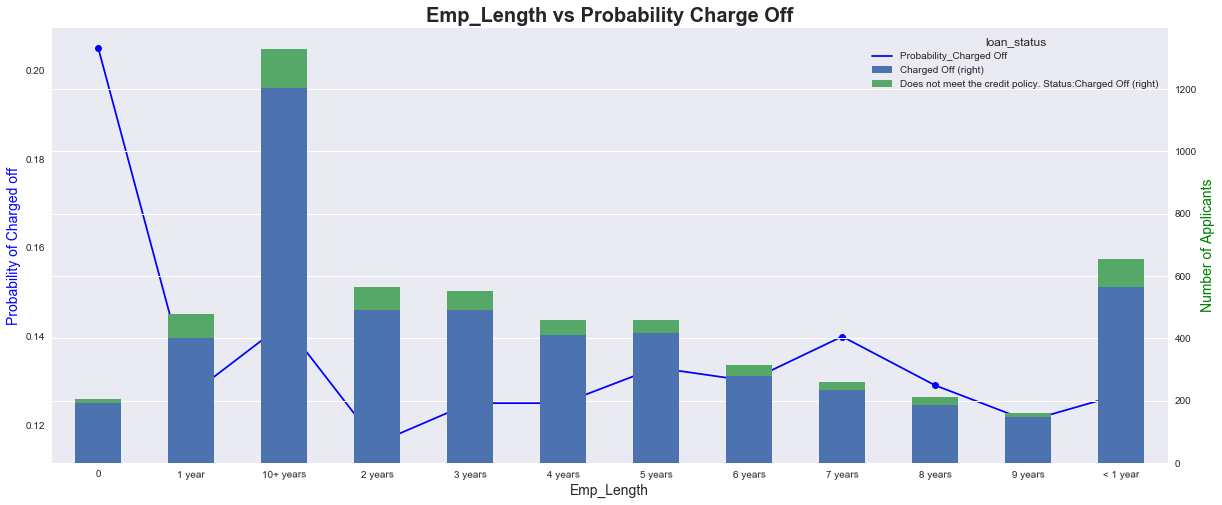

In [47]:
emp_length = crosstab(loan,'emp_length')
display(emp_length)

bivariate_prob(df =loan,col ='emp_length')

Insights: Applicants who are self employed & less than 1 year of experience are more probable of charged off.

# HeatMap: All continuos variables

In [48]:
loan_correlation = loan.corr()
loan_correlation

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,last_fico_range_high,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,acc_now_delinq,delinq_amnt,pub_rec_bankruptcies,tax_liens,loan_income_ratio
loan_amnt,1.0000,0.9811,0.9287,0.3035,0.9279,0.2725,0.0687,-0.0312,-0.0290,0.1699,-0.0563,0.2605,0.2555,0.0106,0.8797,0.8414,0.8463,0.7260,0.0513,0.1333,0.0732,0.4407,-0.0066,-0.0044,-0.0427,-0.0065,0.5928
funded_amnt,0.9811,1.0000,0.9470,0.3063,0.9546,0.2681,0.0684,-0.0320,-0.0281,0.1682,-0.0570,0.2565,0.2496,0.0123,0.8961,0.8573,0.8646,0.7333,0.0542,0.1344,0.0756,0.4453,-0.0064,-0.0044,-0.0436,-0.0066,0.5807
funded_amnt_inv,0.9287,0.9470,1.0000,0.2897,0.8876,0.2492,0.0732,-0.0421,-0.0745,0.1495,-0.0595,0.2170,0.2387,0.0179,0.8707,0.9107,0.8377,0.7234,0.0276,0.1151,0.0557,0.4350,-0.0137,-0.0068,-0.0504,-0.0068,0.5473
int_rate,0.3035,0.3063,0.2897,1.0000,0.2810,0.0551,0.1204,0.1544,0.1787,0.0305,0.1026,0.0873,-0.0258,-0.0035,0.3021,0.2896,0.1818,0.5220,0.1014,0.1233,0.0736,0.1499,0.0034,0.0026,0.0877,0.0017,0.2013
installment,0.9279,0.9546,0.8876,0.2810,1.0000,0.2746,0.0576,-0.0181,-0.0087,0.1692,-0.0498,0.2714,0.2316,0.0115,0.8440,0.7951,0.8386,0.6273,0.0655,0.1178,0.0771,0.3919,-0.0048,-0.0039,-0.0380,-0.0065,0.5275
annual_inc,0.2725,0.2681,0.2492,0.0551,0.2746,1.0000,-0.1201,0.0200,0.0286,0.1599,-0.0174,0.2705,0.2370,0.0053,0.2546,0.2403,0.2563,0.1833,0.0139,0.0248,0.0172,0.1362,-0.0011,-0.0019,-0.0169,-0.0020,-0.2413
dti,0.0687,0.0684,0.0732,0.1204,0.0576,-0.1201,1.0000,-0.0391,0.0094,0.2966,-0.0062,0.1924,0.2379,0.0032,0.0686,0.0722,0.0460,0.1078,-0.0125,0.0217,0.0074,0.0062,-0.0141,-0.0099,0.0061,-0.0037,0.1493
delinq_2yrs,-0.0312,-0.0320,-0.0421,0.1544,-0.0181,0.0200,-0.0391,1.0000,0.0205,0.0140,0.0066,-0.0433,0.0647,-0.0054,-0.0218,-0.0317,-0.0378,0.0230,0.0360,0.0126,0.0156,-0.0144,0.0786,0.1312,0.0046,-0.0015,-0.0633
inq_last_6mths,-0.0290,-0.0281,-0.0745,0.1787,-0.0087,0.0286,0.0094,0.0205,1.0000,0.0964,0.0615,0.0090,0.0940,0.0024,-0.0544,-0.0849,-0.0699,-0.0110,0.0634,0.0388,0.0384,-0.0073,0.0029,0.0167,0.0496,0.0236,-0.0578
open_acc,0.1699,0.1682,0.1495,0.0305,0.1692,0.1599,0.2966,0.0140,0.0964,1.0000,0.0063,0.2535,0.6887,-0.0005,0.1536,0.1394,0.1512,0.1196,-0.0095,0.0168,0.0061,0.0711,-0.0050,-0.0028,0.0104,-0.0028,-0.0561


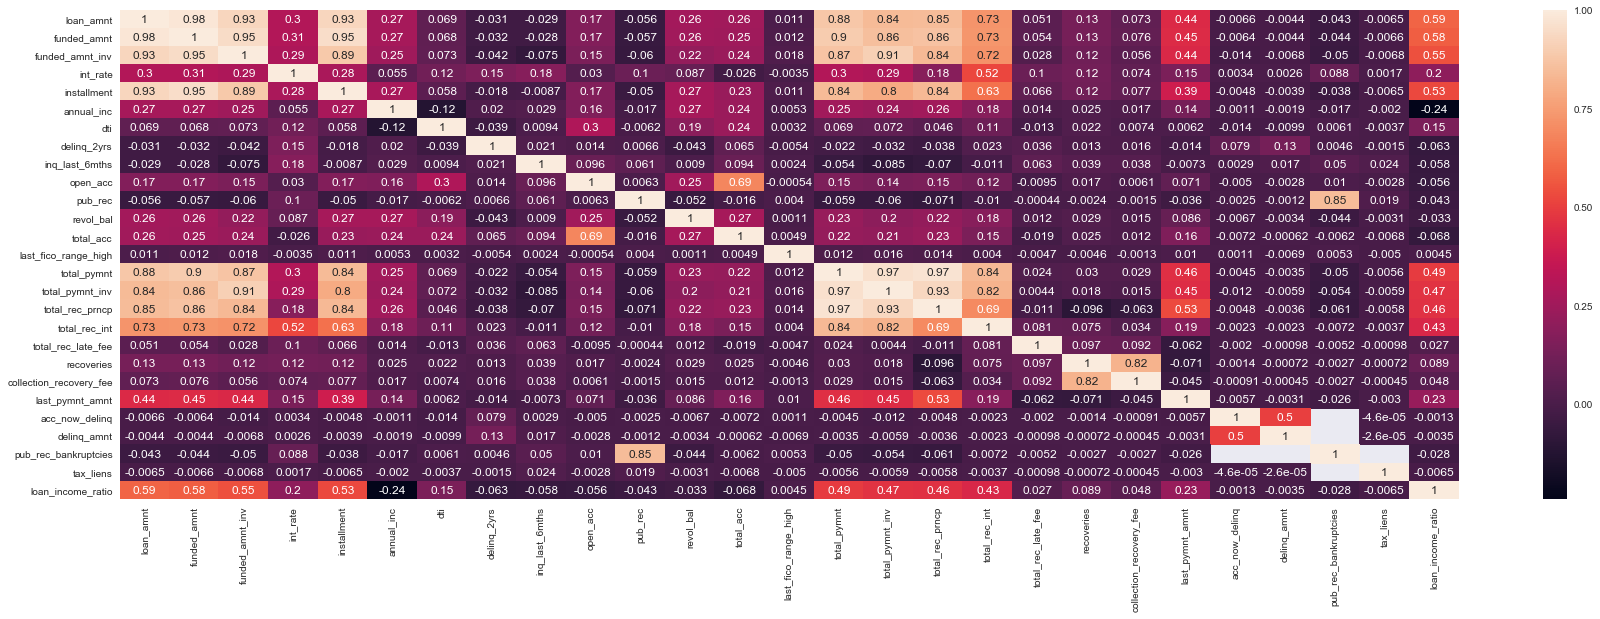

In [49]:
f, ax = plt.subplots(figsize=(30, 9))
sns.heatmap(loan_correlation, 
            xticklabels=loan_correlation.columns.values,
            yticklabels=loan_correlation.columns.values,annot= True)
plt.show()
